# Assignment 2
## Part A: Psychometric curves
**In this assignment, we will see how to study binary decisions:**
- using the **psychometric curve** to describe how decisions depend on a single stimulus feature 
- define the **psychometric model** as a simple statistical model that links one property of the stimulus with participant choices
- learn about the generic concept of **maximum likelihood estimation** to fit a statistical model to experimental data

<div class="alert alert-block alert-warning">
<b>Preparing for this assignment:</b> 

The following resources will help you to get ready to complete this assignment. 
<ul>
    <li>Watch <a href="https://www.youtube.com/watch?v=yIYKR4sgzI8" target="_blank">this video</a> to have a quick overview of linear and logistic regression, a form of generalized linear regression, and how they compare. You should learn: </li>
    <ul>
        <li>what type of data is appropriate for logistic regression modeling</li>
        <li>how we can decide among candidate predictors using regression</li>
        <li>regression fit methods: least-squares versus maximum likelihood</li>
    </ul>
    <li>Watch <a href="https://www.youtube.com/watch?v=vN5cNN2-HWE" target="_blank">this video</a> in order to understand the parameters of a logistic regression:</li>
    <ul>
        <li>concept of link function (<b>logit</b> for logistic regression)</li>
        <li>how to interpret the intercept and slope parameters of predictors in a logistic regression</li>
    </ul>
    <li>Watch <a href="https://www.youtube.com/watch?v=HSHcIHMxhbE" target="_blank">this video</a> to see a step-by-step construction of a multiple linear model with interaction terms. Make sure you understand the logic of the interaction explained in the last half of the video. Take the exercise at the end of the video by stopping the video while you make your calculations.</li>
    <li>Browse <a href="https://en.wikipedia.org/wiki/Interaction_(statistics)" target="_blank">this document</a> about interactions. It focuses a lot on ANOVAs, which we do not plan to address directly, so do not focus too much on that. I suggest reading the introduction, the <i>"In regression"</i> subsection and the <i>"Examples"</i> subsection. </li>
    <li>OPTIONAL: If you were wondering why we skip ANOVAs and are happy just with linear models, ANOVA being such a popular statistical tool, <a href="https://eigenfoo.xyz/tests-as-linear/" target="_blank">here</a> is a more advanced Python document for you to make the point that linear models are a very general framework, which includes many of the classical statistical tests (also ANOVAs). We can run all our tests with linear models!!
</ul>
</div>

### Experiment, scientific question and objectives 
In this assignment we will investigate data from the same working memory [study](https://journals.physiology.org/doi/full/10.1152/jn.00362.2015) as in Assignments 0 and 1, but this time focusing  on the **binary response** experiment (Experiment 1, 8 participants, see Figure 3). In brief, participants were faced again with circular arrays of stimuli (in this experiment there could be 3 or 4 colored dots) while fixating. Following the delay period (in this experiment delays were variable and could be 0.1, 1 or 3 seconds) a colored probe stimulus appeared slightly displaced relative to the color-matching cue stimulus (with an **angular displacement of 4°,6° or 8° either clockwise or counter-clockwise**). Participants had to **indicate with a button press whether this displacement was in the clockwise (CW, response 1) or counter-clockwise (CCW, response -1) direction**. (See figure below taken from Figure 3 of the article)

So, the important differences with the previous design are:
 - responses are not continuous (an angular location taking arbitrary values from 0º to 360º) but categorical (CW or CCW, with just two possible discrete responses). In fact there are just two categories so these responses are binary.
 - apart from the angular displacement of the target w.r.t. the probe as in our previous assignment, there are **three other experimental variables** that vary from trial to trial: **memory load** (3 or 4 items), **delay duration** (0.1, 1 or 3 s), and whether the **nearest distractor is located CW or CCW to the target**.

We want to understand how these factors of interest impact the behavior, which will help us draw some conclusions about the properties of visual working memory. Specifically, as for the other dataset with continous responses (Experiment 2, Assignment 1), we will want to **test whether distractor stimuli have an attracting effect on the item represented in working memory**. By addressing this real research question, we will learn the main concepts and associated methods to analyze binary choice datasets:
 - psychometric curve, to relate the performance to a single factor of interest
 - logistic regression, to relate the performance to multiple factors of interest
 - interactions (to identify possible interactions of these factors)

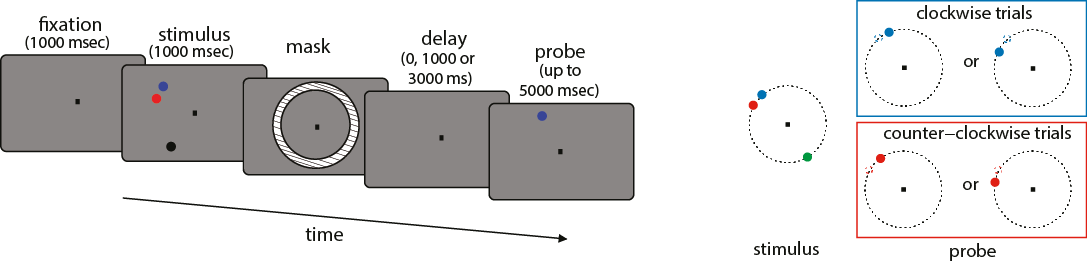

 Let's start by importing the typical libraries (Numpy for basic data operation, Matplotlib for plotting, Pandas to deal with dataframes).

In [1]:
#we first load packages that we will need
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Importing the data
First thing first, let's import the data. Now that you're familiar with Pandas, we will directly import the data (stored as a CSV file) into a dataframe using the function *pd.read_csv*. As for previous assignments, each row in the table correspond to a trial. The columns contain the experimental variables for the corresponding trial: subject response (1=CW, -1=CCW); angle of the probe stimulus ("probe"); angle of the target ("target"); angle of nearest non-target ("near"); subject number; trial load (3 items/4 items, "load"); delay duration (0.1/1/3 seconds, "delay"). Here, all angles are expressed in degrees (not radians)!


In [2]:
# load the data
df = pd.read_csv("https://raw.githubusercontent.com/wimmerlab/MBC-DataAnalysis/main/A2_LogisticRegression/Experiment1_all_subjects.csv")

# visualize the first 10 rows
df.head(10)

,subject,load,delay,target,probe,near,response
0,1,3,0.1,24,18,10,-1
1,1,3,0.1,307,311,296,-1
2,1,3,0.1,151,147,289,1
3,1,4,0.1,326,334,32,-1
4,1,3,0.1,73,77,60,-1
5,1,3,0.1,85,79,70,1
6,1,4,0.1,213,219,226,-1
7,1,4,0.1,250,258,301,-1
8,1,4,0.1,102,108,114,1
9,1,3,0.1,232,238,133,-1


## 1 Plotting the psychometric curve

The psychometric curve is used in discrimination or detection tasks to represent how the choice of the participant depends on the property of the stimulus that is varied across trials, e.g. the contrast in visual detection tasks, the motion in motion discrimination task, the sound intensity in auditory detection tasks, etc. In this experiment the relevant property that determines the choice of the subject (CW/CCW) is the angular displacement between the probe stimulus and the target stimulus. We have used this displacement already in Assignment 1, let us compute it again and add it to the dataframe. We will use the function *circdist_deg* to compte the distance between two angles, as in previous assignments.

In [3]:
# 1. Define a function that takes two angles as input and outputs the angular distance between the two
def circdist_deg(angles1,angles2): #define the name and set the arguments between parentheses
    angle_diff = angles2 - angles1 # simple difference
    angle_diff_rad = angle_diff*np.pi/180 # convert to radians
    angular_dist_rad = np.angle( np.exp(1j*(angle_diff_rad))) ## mathematical operation to get the circular distance (in radians)
    angular_dist = 180/np.pi*angular_dist_rad ## convert back to degrees
    output = np.round(angular_dist) # round value to eliminate numerical imprecisions (all values are integer)
    return output #return the circular distance in degrees 

# 2. Compute the displacement of the probe from the target and add it as a new column to the dataframe: 
df['displacement'] = circdist_deg( df['target'], df['probe'] );

# 3. Check that what we did makes sense (positive values should indicate CCW displacements of the probe)
df.head(10)

,subject,load,delay,target,probe,near,response,displacement
0,1,3,0.1,24,18,10,-1,-6.0
1,1,3,0.1,307,311,296,-1,4.0
2,1,3,0.1,151,147,289,1,-4.0
3,1,4,0.1,326,334,32,-1,8.0
4,1,3,0.1,73,77,60,-1,4.0
5,1,3,0.1,85,79,70,1,-6.0
6,1,4,0.1,213,219,226,-1,6.0
7,1,4,0.1,250,258,301,-1,8.0
8,1,4,0.1,102,108,114,1,6.0
9,1,3,0.1,232,238,133,-1,6.0


If subjects were perfect, they would always respond CCW (-1) when that quantity is positive, and CW (+1) when that quantity is negative. They are not (sorry for the late disappointment about the true nature of humankind). Still, they hopefully don't respond at chance level, so we expect to see that they will tend to respond more CCW for positive values (and even more so if the distance is large), and and more CW otherwise (again, even more so if the distance is large). This is exactly what we want to capture with the psychometric curve: **how the proportion of CW/CCW choices depend on the displacement of the probe w.r.t the target**. To do so, we want to group trials for each possible value of the angular displacement and compute the proportion of CW/CCW responses for each group separately.<br> 
First let us check **how many different values the *displacement* measure takes**. Write the code below (reminder: we computed something similar in Assignment 0). 

In [4]:
# compute the number of different values
nDisplacement = len(np.unique(df['displacement']))
print(nDisplacement)

6


**Is this the number you expected? Why?** Check the experimental design.

Yes, there are 3 different possible distances (4º, 6º or 8º) and two different directions (CW/CCW) so 2x3=6 possible values for the displacements: -8,-6,-4,4,6,8.

Ok so now let's focus on one value of the angular displacement (say +4º). **Compute the proportion of CCW responses for all trials where the angular displacement is of +4 degrees**. 

In [5]:
# first we create a boolean array where value is TRUE if the angular distance is 4 degrees
meetConditions = df['displacement']==4

# select array of responses for all corresponding trial
response_displacement4 = df['response'][meetConditions]

# now compute the proportion of CCW responses for these trials
np.mean(response_displacement4==-1)

0.6909722222222222

We also want some idea of the reliability of this measure. For binary measures, we do not use the standard error of the mean but the following error function:

In [6]:
# this function takes a vector of binary variable as input and outputs the error about the mean
def binary_error(X):
    m = np.mean(X) # mean value
    err = np.sqrt(m*(1-m)/len(X)) # error: sqrt( mean*(1-mean)/nSamples)
    return err

**Use this function to compute the standard error for the mean proportion of CCW responses (in trial with distance = 4 degrees).**

In [7]:
binary_error(response_displacement4==-1)

0.01925386010808333

Good. Now we want to repeat this **for** all possible values of the displacement, which is why we're going to use a *for* loop. Fill in the code below to compute the mean and standard error for all values:

In [8]:
# initialize arrays for mean (and sem) as empty arrays (we will append values in the for loop)
mean_resp = []
sem_resp = []

# compute the unique values taken by the angular displacement 
dist_unique = np.unique(df['displacement'])

# loop through all values of angular displacement
for x in dist_unique:
    # first we create a boolean array where value is TRUE if the angular displacement corresponds to the current value
    meetConditions = df['displacement']==x

    # responses for the corresponding trials
    subsetResp = df['response'][meetConditions]
    
    # boolean array that is true if the corresponding responses is CCW
    isCCW = subsetResp==-1
    
    # now compute the average proportion of CCW responses for these trials, and append
    mean_resp.append( np.mean(isCCW) )
    
    # and finally compute the standard error and append
    sem_resp.append( binary_error(isCCW) )

And we're now ready to plot our first psychometric curve! Using the function *errorbar* from matplotlib, **plot, for each value of the angular displacement, an error bar centered on the proportion of CW choices for the corresponding trials** (and the length of the error bar is set by the standard error of the mean). The value along the X axis should correspond to the angular distances. Do not forget to **add labels on the axes**!

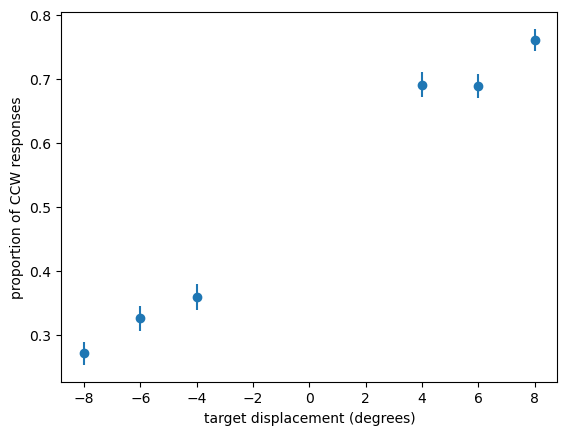

In [9]:
# plot points with errorbars
plt.errorbar(dist_unique ,mean_resp, yerr=sem_resp, fmt="o");

# add labels to the axes
plt.xlabel('target displacement (degrees)');
plt.ylabel('proportion of CCW responses');

**Interpret the plot**.

As expected, we see more CCW than CW responses (i.e. Y values above 0.5) when the displacement is positive, i.e. the probe is located CCW to the target. Conversely, there are more CW than CCW responses (i.e. Y values below 0.5) when the displacement is negative, i.e. probe located CW to the target. In other words, subjects perform above chance (but very far from perfect). The larger is the distance in absolute values, the better are the subjects (i.e. the closer to 1 for CCW and 0 for CW).

Now this: there is a more compact way in python to use the for loop **within** a line command. See below how we are using it to compute the psychometric curves. This should give you the same plot as the one you found.

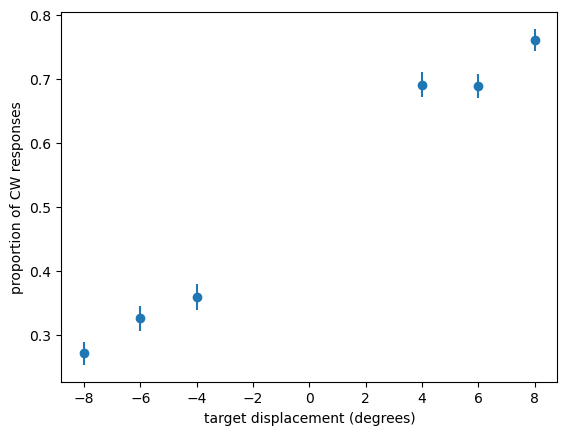

In [10]:
resp = df['response'] #the responses of the experiment
target_dist = df['displacement'] #the probe displacement shown
target_dist_unique = np.unique(target_dist) #the unique values of different probe_target distances shown

# here is the trick, we loop through unique values of distance to populate the array

#mean of responses, for each different probe_target distance
mean_resp =[np.mean(resp[target_dist==x]==-1) for x in target_dist_unique] 

#sem of responses, for each different probe_target distance
sem_resp =[binary_error(resp[target_dist==x]==-1) for x in target_dist_unique] 

plt.errorbar(dist_unique ,mean_resp, yerr=sem_resp, fmt="o");
plt.xlabel('target displacement (degrees)');
plt.ylabel('proportion of CW responses');

## 2 The psychometric function
The plot below summarize the dependence of judgments for a few different values of target displacement. We would like to formalize this into a simple model that captures the statistical relationship between the target displacement and the choice. More specifically, the model will characterize the probability of a CCW $p(CCW)$ response as a function of target distance $d$. We cannot use a simple linear relationship $p(CCW) = w_0 + w_1 d$ because this would predict that as $d$ goes to infinity (either $+ \infty$ or $-\infty$), $p(CCW)$ would also go to infinity. But $p(CCW)$ is a probability so it is **bounded between 0 and 1**. So we need to introduce a non-linearity that maps all continuous values onto values in the range [ 0 1]. This is obtained by using a sigmoidal function. A very classical example of sigmoidal function is the logistic function $\sigma$:
<br> 
$\sigma(x) = \frac{1}{1+ e^{-x}}$
<br>
You really don't need to know (or understand) the formula, but here is how the function looks like:

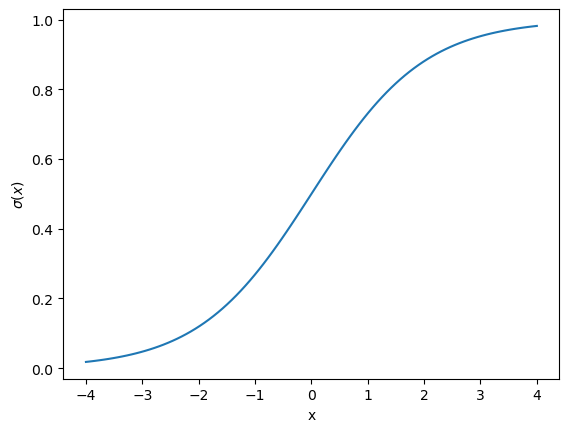

In [11]:
# let's define the logistic function
def logistic(x):
    y = 1/(1+np.exp(-x))
    return y

# to plot a function, we first make an array with many values (here 100) 
#paving all the space in a certain range (here, from -4 to 4)
X = np.linspace(-4,4,100)

# then we compute the value of the function at each of these values
Y = logistic(X)

# and then we just plot the curve joining the dots: easy!
plt.plot(X,Y,'-');

# (and don't forget the labels)
plt.xlabel('x');
plt.ylabel('$\sigma(x)$');

See, a sigmoidal function with values bounded between 0 and 1, just as we wanted! <br>
You can evaluate the function at different values just so you see you understand how it works:

In [12]:
print(logistic(0))

0.5


Now, we will plug our linear model of angular displacement into this sigmoidal function, which gives us the formula: <br>
$p(CCW) = \sigma(w_0 + w_1 d) = \frac{1}{1+ e^{-(w_0 + w_1 d)}}$

This is our psychometric model. It gives a probability of response CCW as a function of angular displacement $d$. It has two parameters $w_0$ and $w_1$, similarly to simple linear regression. We'll see their role in a minute.
**Write a function that takes 3 arguments as input (the displacement $d$, parameter $w_0$ and parameter $w_1$) and outputs the corresponding probabiliy of response CCW according to the model**.

In [13]:
# this is where we define our simple logistic model
def psychometric_model(d, w0, w1):
    #compute the probability of CCW using the formula above
    p = logistic(w0 + w1*d)
    
    #return that probability
    return p

Now we will see how the function defined by our model depends on the parameter by changing the parameters and see how this affects the plot of the probability as a function of displacement. <br>
**Plot the plot of $p(CCW)$ versus $d$ (for displacements $d$ in the range -15 to 15) according to the model, setting the values of $w_0$ to -1 and $w_1$ to 0.3.**

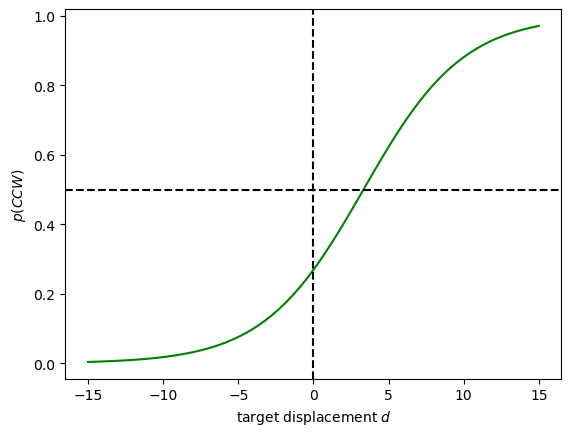

In [14]:
# define the value of the parameters
w0 = -1
w1 = 0.3

# define an array of displacements spanning the range -15 to 15
d = np.linspace(-15,15,100)

# compute the corresponding p(CCW) for each of these values (using the function that we defined above)
pCCW = psychometric_model(d, w0, w1)

# plot
plt.plot(d,pCCW,'g-');

# we add a vertical line at d=0 (i.e. when the target is at the same angle as the probe)
plt.axvline(x = 0, color = 'k', linestyle = '--')

#and horizontal line a pCW = 0.5 (i.e. equal probability of CW and CCW responses)
plt.axhline(y = 0.5, color = 'k', linestyle = '--')

# (and don't forget the labels)
plt.xlabel('target displacement $d$');
plt.ylabel('$p(CCW)$');

Change the values of the parameters $w_0$ and $w_1$ in the code above and see how the curve changes.
**Interpret the role of these two parameters in the model** (Hint: compare with simple linear regression)

$w_1$ sets the **sensitivity** of the dependent variable $p(CCW)$ on the factor $d$, i.e. the weight of $d$ on $p(CCW)$. The larger the value, the steeper the slope. $w_0$ sets the $bias$ of the curve (or the intercept, just as in linear regression). It sets the probability of CCW response when the factor is null (because $p(CCW|d=0) = \sigma(w_0+ w1*0) = \sigma(w_0)$. If $w_0$ is null, then at $d=0$ both responses are equally likely (since $\sigma(0)=0.5$). A positive value of $w_0$ means a bias towards CCW responses, a negative value means a bias towards CW responses.

Now we are going to do something which is both fantastic and trivial. Copy two bits of code below: the code to plot the psychometric model and the code to plot the psychometric curve for experimental data. Now we can see in the **same plot how much the psychometric model is compatible with the data**.

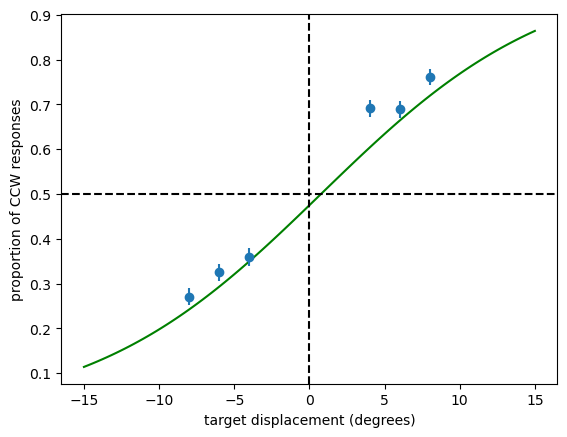

In [15]:
# copy here your code for plotting the psychometric model
# define the value of the parameters
w0 = -0.1
w1 = 0.13

# define an array of values spanning the range -15 to 15
d = np.linspace(-15,15,100)

# compute the corresponding p(CCW) for each of these values (using the function that we defined above)
pCCW = psychometric_model(d, w0, w1)

# plot
plt.plot(d,pCCW,'g-');

# we add a vertical line at d=0 (i.e. when the target is at the same angle as the probe)
plt.axvline(x = 0, color = 'k', linestyle = '--')

#and horizontal line a pCCW = 0.5 (i.e. equal probability of CW and CCW responses)
plt.axhline(y = 0.5, color = 'k', linestyle = '--')

# and copy here your plot for plotting the experimental psychometric curve
plt.errorbar(dist_unique ,mean_resp, yerr=sem_resp, fmt="o");
plt.xlabel('target displacement (degrees)');
plt.ylabel('proportion of CCW responses');

**Adjust the values of the parameters $w_0$ and $w_1$ in the code above so that the model provides a reasonable fit of the data.**

## 3 Fitting the psychometric model (Optional)
Great, you have just fitted your first psychometric curve. Now, we would like a more principled and objective way of fitting the model. We cannot use the framework of linear regression because of the non-linearity due to the logistic function.
Instead, we will use a more generic approach: **maximum likelihood estimation**.
We will use the likelihood function as a measure of how well our model fits the data, for a given value of parameters $(w_0,w_1)$. This will provides an objective function that we will maximize over the parameter space (i.e. the sets of all possible combinations for the two parameters).
Note that this method is very powerful and that could use it to **fit basically any model to any experimental dataset**. You *just* need to be able to write a function that computes how likely is each data point, given a certain value of the parameters.

But let's do it step by step. We'll explore what likelihood means here. <br>
The likelihood for one single trial is basically the probability that the model would produce the same response as observed for that trial. So basically if the subject responded CCW it is just $p(CCW)$ as defined by the model; if she responded CW it is $p(CW) = 1-p(CCW)$. This probability obviously depends on the value of the parameters.<br>
Write a function that takes as input parameter $w_0$, parameter $w_1$, the displacement $d$ for one trial and an observed response (either -1 or +1), and outputs the likelihood for that trial according to the model. (You can call the function *psychometric_model* from your function).

In [16]:
# here goes our function
def single_likelihood(w0,w1,d,resp):
    
    # probability of a CCW response given by the model
    pCCW = psychometric_model(d,w0,w1)   
    
    if (resp==1): # if actual response is CW
        # likelihood is 1-p(CCW)
        p = 1-pCCW
    else:
        # if actual response is CCW
        # likelihood is p(CCW)
        p = pCCW
        
    return p

Use this function to **evaluate the likelihood of the first trial of the dataset**, for $w_0 = 0$ and  $w_0 = 0.4$ (you can change these values and see how the likelihood changes.

In [17]:
# define value of parameters
w0 = 0
w1 = 0.4

# evaluate function here
p = single_likelihood(w0,w1, df['displacement'][0], df['response'][0])

print(p)

0.08317269649392235


Good! Now this was just for one trial, when we need to compute the likelihood of the whole dataset. Because in our model these are independent observations, this likelihood for the whole dataset is obtained by taking the product of the likelihoods obtained for each trial independently. Well it's actually more convenient to turn than into logarithms, and so the log-likelihood of the datasets is the sum of the log-likelihood for individual trials ( no worries if you do not follow that part). 
We are going to call this log-likelihood $L(w_0,w_1)$ which is a function of both parameters.
**Complete the holes to write a function that computes the log-likelihood of model for a given value of the parameters**. Note that our function will take the dataset dataframe as input, and loop through all trials in the dataframe.

In [18]:
def LogLikelihood(w0,w1, df):
    #extract the array of probe displacements from the dataframe
    dist = df['displacement']
    
    #extract the array of responses from the dataframe
    resp = df['response']
    
    #initialize the LLH (a sum of terms) at 0
    LLH = 0
        
    #loop through all trials
    for t in range(len(dist)):
        # compute the likelihood of the corresponding trial
        #(use the function we defined previously)
        lh = single_likelihood(w0,w1,dist[t],resp[t])
        
        #add up the log of this value to LLH
        LLH += np.log(lh)
        
    return LLH

Use the cell below to **evaluate that log-likelihood for different values of the parameters**. 
The absolute value does not matter, we just care about relative values (i.e. parameters that give large values w.r.t other parameters). Note that the LLH is always negative. That's because each probability is lower (or equal) to 1, so its logarithm is negative, and so the sum of negative terms is negative.

In [19]:
print(LogLikelihood(0,.2,df))

-2217.3675652058973


We're almost there! Now we want to maximize the value of the LLH over the space of parameters. To simply things, we will just maximize it over parameter $w_1$ assuming that $w_0=0$ (i.e. no response bias).
**Plot the value of the log-likelihood of the model as a function of $w_1$ (in the range from -0.3 to 0.3), assuming $w_0=0$.**

We can extract the maximum-likelihood value of the parameter (often noted $\hat w_1$) by looking at the value of $w_1$ in our array that maximizes the likelihood. Fill the code below to print the value of this parameter and add a vertical line in the LLH plot at the corresponding value.

MLE value for w1: 0.13636363636363635
maximum LLH: -2163.4537727345546


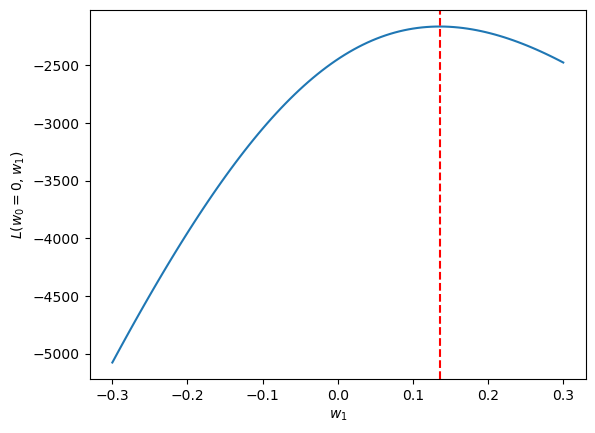

In [20]:
# 1. Plot the Log-Likelihood as a function of w1

# define the value of the parameters
w0 = 0

# define an array of values spanning the range -0,3 to 0.3
w1_all = np.linspace(-0.3,0.3,100)

# initialize the array storing the values of the LLH
LLH_all = []

#loop through all values of w1
for w1 in w1_all:
    
    # compute the LLH at these values of the parameters and append
    LLH_all.append( LogLikelihood(w0, w1, df))

# plot
plt.plot(w1_all,LLH_all,'-');
plt.xlabel('$w_1$');
plt.ylabel('$L(w_0=0,w_1)$');

# 2. Print and plot the MLE value of w1

# find the index in the array where the maximum value of the LLH is reached
i_max = np.argmax(LLH_all) # hint: np.argmax


# and now the corresponding value of w1
w1_hat = w1_all[i_max]

# add a vertical line
plt.axvline(x = w1_hat, color = 'r', linestyle = '--')

print(f"MLE value for w1: {w1_hat}")
print(f"maximum LLH: {np.max(LLH_all)}")

**What is the value of the sensitivity parameter $w_1$ where the maximum likelihood is reached? <br>
How does this compare to the value of $w_1$ obtained by fitting the psychometric model by hand?**

The maximum is obtained around $w_1=0.136$, which is consistent with the value fitted by hand.

In part B of the tutorial, we will see how to run maximum-likelihood estimation for the psychometric model efficiently, using the framework of logistic regression.

## 4. Assessing the influence of the distractors
Let's go back to our research question. So far what we have done is computing the proportion of CCW responses as a function of the angular displacement between the probe and the stimulus, and then fitting a statistical model that captures this relationship (the psychometric model). But all that really told us is that subjects seem to be the task appropriately, and the easier it is (the further away are the probe and the stimulus), the better they do. Reassuring, but perhaps not enough to make headlines... <br>
Really, what we are interested in is the influence of distractor on the behavior. More specifically, our hypothesis is that the nearest distractor may have an attractive effect on the representation stored in working memory. In other words, if the distractor is located CW to the target, the memory of the target should drift towards CW, and so by contrast the probe will look more displaced to CCW than it actually is, which should increase the probability of CCW responses. Conversely, if it is located CCW to the target, it should decrase this probability (go back to the figure of the paradigm if you don't get this). Let's explore this idea using the tools of psychometric curves. <br>
First, we need to define the angular distance between the target and the nearest distractor (to see whether it is located CW or CCW).
**Add a column called *'dist_distractor'* to the dataframe that computes this angular distance.**
(As always, we will try to use the functions that we have defined previously)
**Check that the value is positive if the distractor is located CCW to the target, negative otherwise.**

In [21]:
df['dist_distractor'] = circdist_deg( df['target'] , df['near'] )
df.head(10)

,subject,load,delay,target,probe,near,response,displacement,dist_distractor
0,1,3,0.1,24,18,10,-1,-6.0,-14.0
1,1,3,0.1,307,311,296,-1,4.0,-11.0
2,1,3,0.1,151,147,289,1,-4.0,138.0
3,1,4,0.1,326,334,32,-1,8.0,66.0
4,1,3,0.1,73,77,60,-1,4.0,-13.0
5,1,3,0.1,85,79,70,1,-6.0,-15.0
6,1,4,0.1,213,219,226,-1,6.0,13.0
7,1,4,0.1,250,258,301,-1,8.0,51.0
8,1,4,0.1,102,108,114,1,6.0,12.0
9,1,3,0.1,232,238,133,-1,6.0,-99.0


Now **plot two psychometric curves** on the same figure: 
- one corresponding to all trials where the nearest distractor was located CW to the target
- one corresponding to all trials where the nearest distractor was located CCW to the target
Because we expect the effect of the distractor to be larger for longer delays, **restrict your analysis to long delays** (either 1 or 3 s).

We will use the function *psycho_curve* defined below which computes the relevant values of the psychometric curves (displacements and corresponding mean and s.e.m. of CCW responses) from any arrays of displacement and responses. This way we compute the psychometric curve for a certain condition by providing as input to this function the arrays for trials in this condition. Take some time to understand how this function works, which variable it takes as input and which variable it outputs.

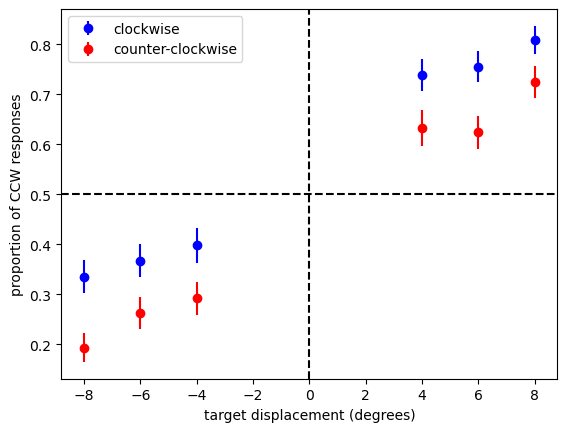

In [22]:
# function that computes (but does not plot) the psychometric curve for a sequence of trials
def psycho_curve(resp, target_dist):
    #the unique values of different probe_target distances shown
    target_dist_unique = np.unique(target_dist) 

    #proportion of CCW responses
    mean_resp =[np.mean(resp[target_dist==x]==-1) for x in target_dist_unique] 

    #sem of CCW proportion, for each different probe_target distance
    sem_resp =[binary_error(resp[target_dist==x]==-1) for x in target_dist_unique] 
    
    # output the mean, sem and corresponding distance values
    return mean_resp, sem_resp, target_dist_unique


#array with the responses of the experiment (all trials) 
resp = df['response']  

#array with the target displacement (all trials) 
target_dist = df['displacement'] 

# 1. Psychometric curve for trials with distractor located CW (and long delays)

# create a boolean array that is true iff the nearest distractor is located CW to the target
is_distractor_CW = df['dist_distractor'] < 0

# create a boolean array that is true iff the delay is long (1s or 3s, i.e. longer than 0.5 s)
is_long_delay = df['delay']>0.5

# create a boolean array that is true if both conditions above are met
# (what boolean operation is this?)
is_both = is_distractor_CW & is_long_delay

#select the responses and target distances for trials that match both conditions
resp_CW_longdelay = resp[is_both]
target_dist_CW_longdelay = target_dist[is_both]

#use the function we defined above to compute the psychometric curve for this set of trials
mean_resp_CW, sem_resp_CW, target_dist_unique = psycho_curve(resp_CW_longdelay, target_dist_CW_longdelay)

# 2. repeat the same operations for trials with CCW distractor (and again long delays)

# create a boolean array that is true iff the nearest distractor is located CW to the target
is_distractor_CCW = df['dist_distractor'] > 0

# create a boolean array that is true iff the delay is long (1s or 3s, i.e. longer than 0.5 s)
is_long_delay = df['delay']>0.5

# create a boolean array that is true if both conditions above are met
# (what boolean operation is this?)
is_both = is_distractor_CCW & is_long_delay

#select the responses and target distances for trials that match both conditions
resp_CCW_longdelay = resp[is_both]
target_dist_CCW_longdelay = target_dist[is_both]

#use the function we defined above to compute the psychometric curve for this set of trials
mean_resp_CCW, sem_resp_CCW, target_dist_unique = psycho_curve(resp_CCW_longdelay, target_dist_CCW_longdelay)


# 3. plot everything  (use option 'label=' to define a label for the legend)

plt.errorbar(dist_unique ,mean_resp_CW, yerr=sem_resp_CW, fmt="bo", label="clockwise");
plt.errorbar(dist_unique ,mean_resp_CCW, yerr=sem_resp_CCW, fmt="ro", label="counter-clockwise");

# we add a vertical line at d=0 (i.e. when the target is at the same angle as the probe)
plt.axvline(x = 0, color = 'k', linestyle = '--')

#and horizontal line a pCCW = 0.5 (i.e. equal probability of CW and CCW responses)
plt.axhline(y = 0.5, color = 'k', linestyle = '--')

plt.xlabel('target displacement (degrees)');
plt.ylabel('proportion of CCW responses');
plt.legend();

**How do you interpret the figure?**

We see that when distractor is located CW to the target, the proportion of CW responses is increased, irrespective of the value of the target displacement. This shows an **attracting effect of the distractor (at long delays)**.